In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
print("pytorch ver . ",torch.__version__)
print("Is CUDA available?",torch.cuda.is_available())
import torch.nn as nn
import torch.optim as optim

pytorch ver .  1.11.0+cu113
Is CUDA available? True


/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read data

In [4]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/data_final.csv')

# Generate X Y 

In [5]:
x1=np.zeros([604,1704])
x2=np.zeros([604,5112])

#x1 (0th~1703th column as x)
for i in range (0,604):
    for j in range (0,71):
        a=np.array(data['pm25_obs'][5112*i+72*j:5112*i+72*j+24])
        for k in range (0,24):
            x1[i][j*24+k]=a[k]

#x2 (1704th~8519th column as x)
for i in range (1,604):
    b=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    for j in range(0,5112):
        x2[i-1][j]=b[j]
        
print(np.shape(x1))
print(np.shape(x2))

(604, 1704)
(604, 5112)


In [6]:
x1Restruct_Fun=x1
x2Restruct_Fun=x2
print(np.shape(x1Restruct_Fun))
print(np.shape(x2Restruct_Fun))

(604, 1704)
(604, 5112)


In [7]:
YRestruct_Fun=np.zeros([601,5112])
for j in range (0,71):
    for i in range(0,601):
        YRestruct_Fun[i][72*j:72*j+24]=x1Restruct_Fun[1+i][24*j:24*j+24]
        YRestruct_Fun[i][72*j+24:72*j+48]=x1Restruct_Fun[1+i+1][24*j:24*j+24]
        YRestruct_Fun[i][72*j+48:72*j+72]=x1Restruct_Fun[1+i+2][24*j:24*j+24]
print(np.shape(YRestruct_Fun))

(601, 5112)


In [8]:
XRestruct_Fun=np.zeros([601,6816])
for i in range (0,601):
    for j in range (0,1704):
        XRestruct_Fun[i][j]=x1Restruct_Fun[i][j]
    for j in range (1704,6816):
        XRestruct_Fun[i][j]=x2Restruct_Fun[i][j-1704]
print(np.shape(XRestruct_Fun))

(601, 6816)


In [9]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
X1hat_train = np.zeros([540,1704])
X2hat_train = np.zeros([540,5112])
Yhat_train = np.zeros([540,5112])
X1hat_test = np.zeros([61,1704])
X2hat_test = np.zeros([61,5112])
Yhat_test = np.zeros([61,5112])
for i in range (0,540):
    for j in range (0,1704):
        X1hat_train[i][j] = Xhat[i][j]
    for j in range (1704,6816):
        X2hat_train[i][j-1704] = Xhat[i][j]
    for j in range (0,5112):
        Yhat_train[i][j] = Yhat[i][j]
for i in range (540,601):
    for j in range (0,1704):
        X1hat_test[i-540][j] = Xhat[i][j]    
    for j in range (1704,6816):
        X2hat_test[i-540][j-1704] = Xhat[i][j]
    for j in range (0,5112):     
        Yhat_test[i-540][j] = Yhat[i][j]
        
print('X1hat_train')
#print(X1hat_train)
print(np.shape(X1hat_train))
print('X2hat_train')
#print(X2hat_train)
print(np.shape(X2hat_train))
print('Yhat_train')
#print(Yhat_train)
print(np.shape(Yhat_train))
print('X1hat_test')
#print(X1hat_test)
print(np.shape(X1hat_test))
print('X2hat_test')
#print(X2hat_test)
print(np.shape(X2hat_test))
print('Yhat_test')
#print(Yhat_test)
print(np.shape(Yhat_test))

X1hat_train
(540, 1704)
X2hat_train
(540, 5112)
Yhat_train
(540, 5112)
X1hat_test
(61, 1704)
X2hat_test
(61, 5112)
Yhat_test
(61, 5112)


# Modeling

In [10]:
x1 = X1hat_train
x2 = X2hat_train
y = Yhat_train
xt1 = X1hat_test
xt2 = X2hat_test
yt = Yhat_test

In [11]:
def model (x1,x2,b0,b1,b2):
    y = b0 +  torch.matmul(x1,b1) + torch.matmul(x2,b2)
#    y = b0 + torch.matmul(x2,b2)
    return y

In [12]:
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)


beta0 = torch.ones(5112 , requires_grad = True)
beta1 = torch.ones([1704,5112], requires_grad = True)
beta2 = torch.ones([5112,5112], requires_grad = True)
#beta2 = torch.ones([6816,5112], requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)

epo = 2001
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
    r = torch.abs(yhats_test - y_test)
    test_loss = torch.mean(r)
    test_error[epoch] = test_loss

    if epoch <= 10 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                    f" Testing loss {test_loss.item():.4f}")      
    else :
        if epoch >= epo-10 :
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                        f" Testing loss {test_loss.item():.4f}")

Epoch 0, Training loss 94251.3672, Testing loss 99211.3229
Epoch 1, Training loss 94157.1016, Testing loss 99112.0035
Epoch 2, Training loss 94062.8438, Testing loss 99012.6836
Epoch 3, Training loss 93968.5703, Testing loss 98913.3581
Epoch 4, Training loss 93874.3125, Testing loss 98814.0281
Epoch 5, Training loss 93780.0391, Testing loss 98714.7157
Epoch 6, Training loss 93685.7812, Testing loss 98615.4018
Epoch 7, Training loss 93591.5312, Testing loss 98516.0701
Epoch 8, Training loss 93497.2500, Testing loss 98416.7487
Epoch 9, Training loss 93402.9844, Testing loss 98317.4209
Epoch 10, Training loss 93308.7188, Testing loss 98218.1048
Epoch 20, Training loss 92366.0625, Testing loss 97224.9121
Epoch 30, Training loss 91423.4141, Testing loss 96231.6494
Epoch 40, Training loss 90480.7656, Testing loss 95238.4402
Epoch 50, Training loss 89538.1016, Testing loss 94245.2122
Epoch 60, Training loss 88595.4609, Testing loss 93251.9930
Epoch 70, Training loss 87652.8125, Testing loss 9

Epoch 1300, Training loss 4.6463, Testing loss 6.5533
Epoch 1310, Training loss 4.7598, Testing loss 6.7171
Epoch 1320, Training loss 4.9274, Testing loss 6.8070
Epoch 1330, Training loss 4.9417, Testing loss 6.8947
Epoch 1340, Training loss 5.1124, Testing loss 6.9655
Epoch 1350, Training loss 5.2051, Testing loss 7.1257
Epoch 1360, Training loss 5.2191, Testing loss 7.1722
Epoch 1370, Training loss 5.3030, Testing loss 7.2666
Epoch 1380, Training loss 5.4309, Testing loss 7.3878
Epoch 1390, Training loss 5.3960, Testing loss 7.3938
Epoch 1400, Training loss 5.4279, Testing loss 7.3925
Epoch 1410, Training loss 5.5086, Testing loss 7.4695
Epoch 1420, Training loss 5.5795, Testing loss 7.5880
Epoch 1430, Training loss 5.6629, Testing loss 7.5991
Epoch 1440, Training loss 5.6940, Testing loss 7.6627
Epoch 1450, Training loss 5.6699, Testing loss 7.7053
Epoch 1460, Training loss 5.7150, Testing loss 7.7440
Epoch 1470, Training loss 5.7346, Testing loss 7.7366
Epoch 1480, Training loss 5.

# Result

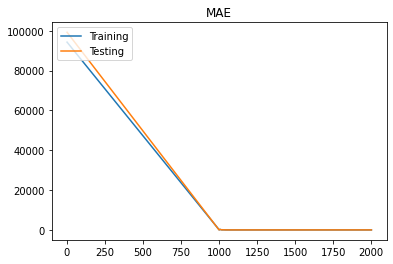

In [13]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,train_error, label = 'Training')
plt.plot(x,test_error, label ='Testing')
plt.legend(loc = 2)
plt.title('MAE')

plt.show()

In [14]:
print(np.min(test_error))

4.976625332326482
